In [16]:
import numpy as np
from matplotlib import pyplot as plt
from os.path import join

from IPython.display import Audio
from keras.layers import Dense, LSTM, Input, Add
from keras.models import load_model
from keras.optimizers import Adam
from keras import Model

from Utilities.DataProcessors.TimeDomain import TimeDomain
from Utilities.Loss import SteinmetzLoss, WrightLoss
from Utilities.Layers.ConditionlessTCN import ConditionlessTCN as TCN

print('Imported')

Imported


In [17]:
''' Define Constants '''
DATA_DIR = 'Data'
MODEL_DIR = 'Models'
RATE = 44100
print('Done')

Done


In [18]:
''' Pre process data '''
td = TimeDomain(rate=RATE, sample_sec=1, data_dir=DATA_DIR)
ip_shape, X_train = td.pre_process('X_train.wav')
ip_shape, Y_train = td.pre_process('Y_train.wav')
assert X_train.shape == Y_train.shape
print(ip_shape)

(52, 44100, 1)


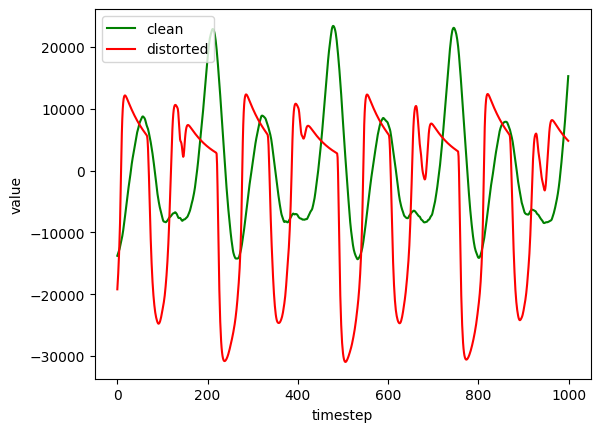

In [3]:
''' Plot X_train and Y_train ''' 

plt.plot(X_train[25][1000:2000], color='green')
plt.plot(Y_train[25][1000:2000], color='red')
plt.xlabel('timestep')
plt.ylabel('value')
plt.legend(['clean', 'distorted'], loc='upper left')
plt.show()

# Observation: Distorted signal closely follows clean closely
# but has high amplitude. Typical of Overdriven signal
# Also, Distorted seems to have lower troughs but marginally higher peaks, if any, when
# compared to clean signal
# Finally DC bias exists.

In [19]:
''' TCN Model of the music data '''

input = Input(batch_shape=ip_shape)
mTCN = TCN(filters=15, dilation=10)(input)
mTCN = TCN(filters=5, dilation=10)(mTCN)
mTCN = Dense(units=1, activation='linear')(mTCN)

model = Model(input, mTCN)

adam = Adam(learning_rate=0.1)
sloss = SteinmetzLoss()
model.compile(optimizer=adam, loss=sloss)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(52, 44100, 1)]             0         []                            
                                                                                                  
 conv1d_12 (Conv1D)          (52, 44100, 15)              60        ['input_4[0][0]']             
                                                                                                  
 batch_normalization_6 (Bat  (52, 44100, 15)              60        ['conv1d_12[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 p_re_lu_6 (PReLU)           (52, 44100, 15)              661500    ['batch_normalization_6[

In [20]:
history = model.fit(X_train, Y_train, epochs=500, validation_split=0.3)

Epoch 1/500
2/2 [==============================] - 6s 1s/step - loss: 10682.4990 - val_loss: 8287.9619
Epoch 2/500
2/2 [==============================] - 2s 474ms/step - loss: 8611.4004 - val_loss: 9341.2207
Epoch 3/500
2/2 [==============================] - 2s 502ms/step - loss: 8805.9658 - val_loss: 8641.6738
Epoch 4/500
2/2 [==============================] - 2s 519ms/step - loss: 8557.7168 - val_loss: 8245.9883
Epoch 5/500
2/2 [==============================] - 2s 547ms/step - loss: 8739.3047 - val_loss: 8285.0693
Epoch 6/500
2/2 [==============================] - 2s 500ms/step - loss: 8620.3496 - val_loss: 8761.4375
Epoch 7/500
2/2 [==============================] - 2s 488ms/step - loss: 8575.6299 - val_loss: 9227.6953
Epoch 8/500
2/2 [==============================] - 2s 463ms/step - loss: 8747.2969 - val_loss: 8906.4756
Epoch 9/500
2/2 [==============================] - 2s 599ms/step - loss: 8603.7988 - val_loss: 8393.1934
Epoch 10/500
2/2 [==============================] - 3s 47

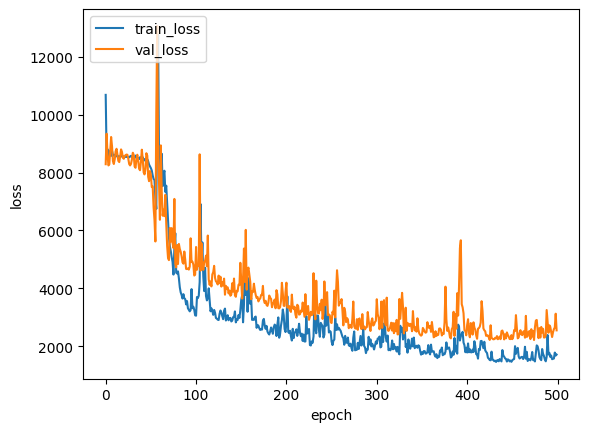

In [21]:
''' Plot train and val loss '''
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

In [22]:
# Save model
model.save(join(MODEL_DIR, 'v3-tcn-Steinmetz.keras'))

In [23]:
# Load the model
model = load_model(join(MODEL_DIR, 'v3-tcn-Steinmetz.keras'), compile=False)
# Compile manually since Keras serialization is not working with custom losses.
model.compile(optimizer=adam, loss=sloss)
print('Loaded and compiled')

Loaded and compiled


In [24]:
# Distort the test sample
_, X_test = td.pre_process('X_test.wav')
_, Y_test = td.pre_process('Y_test.wav')
Y_pred = model.predict(X_test)
print(Y_pred.shape)

1/1 [==============================] - 1s 540ms/step
(17, 44100, 1)


In [26]:
# saving the LSTM predicitons in wav format
wavfile = td.post_process(Y_pred)
td.save('Y_pred.wav', wavfile)

Saved!


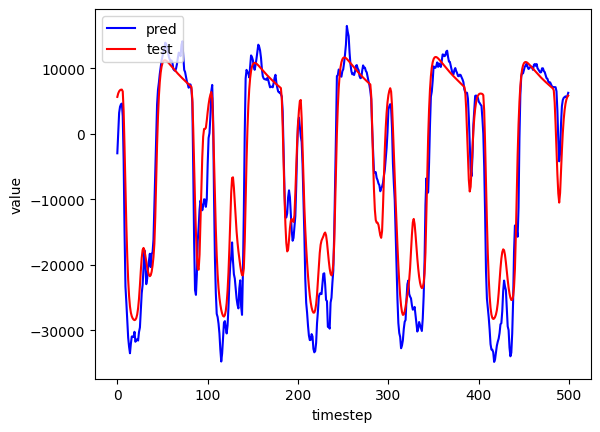

In [25]:
# Plot X_train and Y_train 
plt.plot(Y_pred[10][1000:1500], color='blue')
plt.plot(Y_test[10][1000:1500], color='red')
#plt.plot(X_test[10][1000:1250], color='green')
plt.xlabel('timestep')
plt.ylabel('value')
plt.legend(['pred', 'test', 'clean'], loc='upper left')
plt.show()

In [28]:
# Play Predicted sample  
Audio( 'Data/Y_pred.wav', rate=RATE)